In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau 


import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading the data
data = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [3]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
data.shape

(28619, 3)

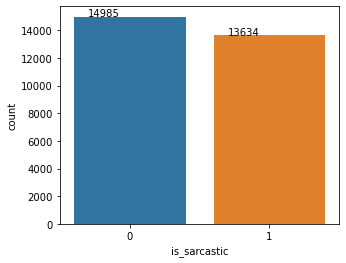

In [5]:
#Checking the class imbalance
plt.figure( figsize=(5,4))
# create count plot
ax = sns.countplot(x='is_sarcastic', data = data)
# annotate
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()+50))

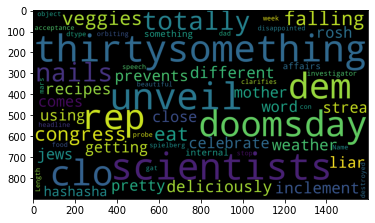

In [6]:
wordcloud = WordCloud(background_color='black',
                    stopwords = STOPWORDS,
                    max_words = 100,
                    random_state = 500, 
                    width=1600, 
                    height=900)
wordcloud.generate(str(data['headline']))
plt.imshow(wordcloud)

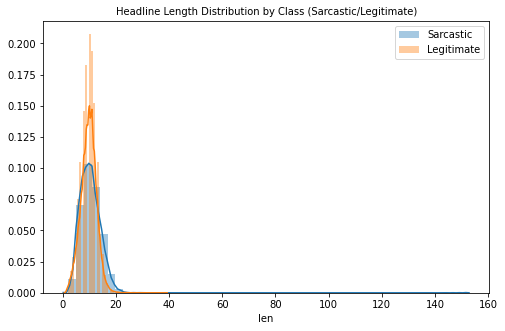

In [7]:
#Checking lentgth of sentences along with distribution.
data['len'] = data.headline.apply(lambda x: len(x.split()))

sarcastic = data[data.is_sarcastic == 1]
legit = data[data.is_sarcastic == 0]

plt.figure(figsize=(8,5))
sns.distplot(sarcastic.len, hist= True, label= 'Sarcastic')
sns.distplot(legit.len, hist= True, label= 'Legitimate')
plt.legend()
plt.title('Headline Length Distribution by Class (Sarcastic/Legitimate)', fontsize = 10)
plt.show()

In [7]:
#List of headlines
headlines = list(data['headline'])
headlines[:20]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep. totally nails why congress is falling short on gender, racial equality',
 'eat your veggies: 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 "mother comes pretty close to using word 'streaming' correctly",
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 "richard branson's global-warming donation nearly as much as cost of failed balloon trips",
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario',
 'this lesbian is considered a father in indiana (and an amazing one at that)',
 "amanda peet told her daughter sex is 'a special hug'",
 'what to know regarding current treatments for ebola',
 "chris christie suggests hillary clinton was to blame for boko haram's kidnapping of hundreds of schoolgirls",
 'ford develops new suv that runs purely on gasoline',
 'uber ceo travis kalanick step

head_tokens = [word_tokenize(head) for head in headlines]

In [8]:
#Defining function to preprocess
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    words = tokenizer.tokenize(document)

    # remove stop words
    words = [word for word in words if word not in stopwords.words("english")]
    
    #stemming
    stemmer = PorterStemmer()
    words_stemmed = [stemmer.stem(word) for word in words]

    # join words to make sentence
    document = " ".join(words_stemmed)
    
    return document

In [9]:
#Cleaned headlines
headlines_prep = [preprocess(headline) for headline in headlines]

In [10]:
head_split = [word_tokenize(x) for x in headlines_prep] #tokinizing to word
flat_list = [item for sublist in head_split for item in sublist] #flattening the list

In [11]:
from nltk import FreqDist
freqDist = FreqDist(flat_list) #frequency list of the entire corpus
freqDist

FreqDist({'trump': 1836, 'new': 1684, 'man': 1535, 'year': 854, 'get': 849, 'report': 772, 'say': 749, 'make': 678, 'day': 613, 'one': 609, ...})

In [12]:
top_10000_words_tup = freqDist.most_common(10000) #top 10000 frequent words (tuples)

In [13]:
top_10000_words = [tup[0] for tup in top_10000_words_tup] #top 10000 words

In [14]:
#Removing characters wich are less frequent
headlines_WO_freq_words = []
for head in headlines_prep:
    head_split = head.split(' ')
    head_new = [word for word in head_split if word in top_10000_words]
    head_new = ' '.join(head_new)
    headlines_WO_freq_words.append(head_new)

In [15]:
#Getting indexes (in the list of top 10000 words) of words
temp = {y:x for x, y in enumerate(top_10000_words)}

headlines_indexed = []
for head in headlines_WO_freq_words:
    head_split = head.split(' ')
    Output = [temp.get(elem) for elem in head_split]
    headlines_indexed.append(Output)

In [16]:
#Numeric representation of sentences
headlines_indexed_str = []
for head in headlines_indexed:
    head_new = [x+1 for x in head if x != None]
    head_new = ' '.join([str(x) for x in head_new])
    #print(head_new)
    headlines_indexed_str.append(head_new)
    
data['headlines_indexed'] = headlines_indexed_str
data.head()

,is_sarcastic,headline,article_link,headlines_indexed
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,308 283 5135 1993 657 1101
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,2575 1545 499 1498 226 321 975 1406 1749 796
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,202 6769 259 1994 397 1183
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8187 1327 667 2576 5 41
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,215 54 301 500 47 260 1995 5136


In [17]:
#train-test split
from sklearn.model_selection import train_test_split
X = data['headlines_indexed']
y = data['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

In [18]:
#Plotting function
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['accuracy'])   
    axes[1].plot(history.history['val_accuracy'])
    axes[1].legend(['accuracy','val_accuracy'])

In [19]:
#Defining Hyperparameters to be used
max_words = 10000     # how many unique words to use (i.e num rows in embedding vector)
max_len = 20       # max number of words in a headline to use
oov_token = '00_V'    # for the words which are not in training samples
padding_type = 'post'   # padding type
trunc_type = 'post'    # truncation for headlines longer than max length
embed_size = 128 

In [20]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [21]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

#### CNN-BiLSTM

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.Conv1D(32,7,activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32,7,activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 14, 32)            28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 32)             7200      
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 64)             16640     
_________________________________________________________________
dense (Dense)                (None, 1, 1)              65        
Total params: 1,332,609
Trainable params: 1,332,609
Non-trainable params: 0
______________________________________________

In [23]:
history = model.fit(train_sequences, y_train, batch_size=512, epochs=10, 
                    validation_data=(test_sequences, y_test), 
                    callbacks=[rlrp] ,verbose=1)

Train on 22895 samples, validate on 5724 samples
Epoch 1/10
22895/22895 [==============================] - 9s 401us/sample - loss: 0.6640 - accuracy: 0.5926 - val_loss: 0.5680 - val_accuracy: 0.7182
Epoch 2/10
22895/22895 [==============================] - 2s 69us/sample - loss: 0.4125 - accuracy: 0.8119 - val_loss: 0.4323 - val_accuracy: 0.7975
Epoch 3/10
22895/22895 [==============================] - 2s 68us/sample - loss: 0.2469 - accuracy: 0.9019 - val_loss: 0.4540 - val_accuracy: 0.8038
Epoch 4/10
22895/22895 [==============================] - 2s 68us/sample - loss: 0.1378 - accuracy: 0.9530 - val_loss: 0.5370 - val_accuracy: 0.7956
Epoch 5/10
22895/22895 [==============================] - 2s 68us/sample - loss: 0.0659 - accuracy: 0.9843 - val_loss: 0.5868 - val_accuracy: 0.7940
Epoch 6/10
22895/22895 [==============================] - 2s 70us/sample - loss: 0.0544 - accuracy: 0.9869 - val_loss: 0.6290 - val_accuracy: 0.7944
Epoch 7/10
22895/22895 [==============================] 

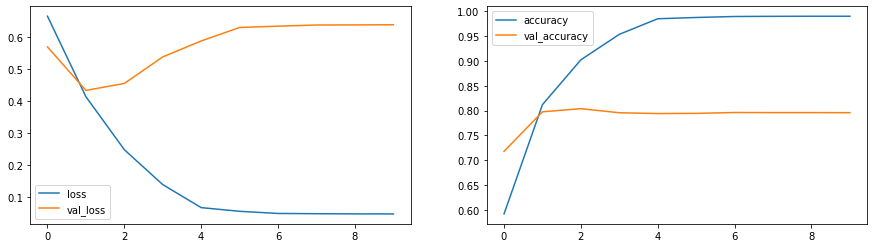

In [24]:
plot(history)